Steps are:

- select a reconstruction time
- the code determines which paleogeography stage this falls within, gets the start and end times
- load the relevant precomputed multipoint files, and in the process assign an integer to the different types for use in interpolation steps (e.g. set land to be 1, shallow marine to be 2, etc)

- for land and marine



In [14]:
import pygplates
import glob, re
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
import xarray as xr

import polygon_processing as pp
import paleogeography as pg
import paleogeography_tweening as pgt

from proximity_query import *
from create_gpml import create_gpml_regular_long_lat_mesh
import points_in_polygons
from sphere_tools import sampleOnSphere
import points_spatial_tree



%matplotlib inline


reconstruction_basedir = './Paleogeography_Matthews2016_410-2Ma_Shapefiles/'
tween_basedir = './tween_feature_collections/'

output_dir = './paleotopo_grids/'

area_threshold = 0.001

sampling = 0.5

#rotation_model = pygplates.RotationModel(['%s/Global_EB_250-0Ma_GK07_Matthews++.rot' % reconstruction_basedir,
#                                          '%s/Global_EB_410-250Ma_GK07_Matthews++.rot' % reconstruction_basedir])
rotation_model = pygplates.RotationModel('%s/Global_EarthByte_230-0Ma_GK07_AREPS.rot' % reconstruction_basedir)


COBterrane_file = '%s/Global_EarthByte_GeeK07_COB_Terranes_Matthews_etal.gpml' % reconstruction_basedir

agegrid_file_template = '/Users/Simon/Data/AgeGrids/Agegrids_30m_20151002_2015_v1_r756/agegrid_30m_%d.grd'


#############################################
## Set the heights for different environment
#############################################
depth_for_unknown_ocean = -1000
# ----------------------------------
shallow_marine_elevation = -200.
# ----------------------------------
lowland_elevation = 200.
# ----------------------------------
max_mountain_elevation = 3000.
# NOTE - this height is actually the mountain height IN ADDITION TO the lowland height
# so that the maximum absolute elevation would be [lowland_elevation + max_mountain_elevation]
#############################################

# the grid sampling for the output
sampling = 0.5

# this number controls how small polygons are exclude when merging the COB terranes into 
# land/sea masking polygons
area_threshold = 0.001

# this buffer defines the smoothness of the topography at the transition from 'lowland' to 'mountain'
# the distance defined here is the distance over which heights ramp from the lowland elevation to the 
# mountain elevation defined above. (the ramping takes place from the edge of the mountain range inwards
# towards the mountain interior). Any parts of the mountain range greater than this buffer distance from 
# the edge will have a uniform height equal to max_mountain_elevation
mountain_buffer_distance_degrees = 1.

# this number is used in the final grdfilter step to smooth the output 
grid_smoothing_wavelength_kms = 400.


####################################################

# make a sorted list of the (midpoint) times for paleogeography polygons
tmp = glob.glob('%s/*/' % reconstruction_basedir)

time_list = []
for tm in tmp:
    time_list.append(float(re.findall(r'\d+Ma+',tm)[1][:-2]))

time_list.sort()

time_list = np.array(time_list)



In [15]:
def write_xyz_file(output_filename, output_data):
    with open(output_filename, 'w') as output_file:
        for output_line in output_data:
            output_file.write(' '.join(str(item) for item in output_line) + '\n')


# define a function that loads paleogeography multipoints at a specified time
# NOTE this time can be anything, not a time where the multipoints fit nicely together,
# hence the gaps and overlaps will be present
def add_reconstructed_points_to_xyz(points_file,rotation_model,reconstruction_time,zval):
    
    reconstructed_points = []
    pygplates.reconstruct(points_file,rotation_model,reconstructed_points,reconstruction_time)
    
    point_array = []
    for reconstructed_point in reconstructed_points:
        point_array.append(reconstructed_point.get_reconstructed_geometry().to_lat_lon_array())
        
    print points_file
    xy_array = np.vstack(point_array)
    xyz_array = np.hstack((xy_array,zval*np.ones((xy_array.shape[0],1))))
    
    return xyz_array


def get_distance_to_mountain_edge(point_array,reconstruction_basedir,time):
    
    distance_threshold_radians=None
    env_list = ['m']

    pg_dir = '%s/PresentDay_Paleogeog_Matthews2016_%dMa/' % (reconstruction_basedir,time)

    pg_features = pg.load_paleogeography(pg_dir,env_list)
    cf = pp.merge_polygons(pg_features,rotation_model,time=time,sampling=0.25)
    sieve_polygons_t1 = pp.polygon_area_threshold(cf,area_threshold)

    polygons_as_list = []
    for feature in sieve_polygons_t1:
        polygons_as_list.append(feature.get_geometry())
        
    res1 = find_closest_geometries_to_points([pygplates.PointOnSphere(point) for point in zip(point_array[:,0],point_array[:,1])],
                                             polygons_as_list,
                                             distance_threshold_radians = distance_threshold_radians)
    
    distance_to_polygon_boundary = np.degrees(np.array(zip(*res1)[0]))

    # Make a copy of list of distances.
    distance_to_polygon = list(distance_to_polygon_boundary)

    # Set distance to zero for any points inside a polygon (leave other points unchanged).
    res2 = points_in_polygons.find_polygons([pygplates.PointOnSphere(point) for point in zip(point_array[:,0],point_array[:,1])],
                                            polygons_as_list)

    for point_index, rpolygon in enumerate(res2):
        # If not inside any polygons then result will be None.
        if rpolygon is None:
            distance_to_polygon[point_index] = 0.0
            
    return distance_to_polygon


# This cell uses COB Terranes to make a masking polygon
# (which is called 'seive_polygons')
def get_merged_cob_terrane_polygons(COBterrane_file,reconstruction_time,sampling):

    polygon_features = pygplates.FeatureCollection(COBterrane_file)

    cobter = pp.force_polygon_geometries(polygon_features)

    cf = pp.merge_polygons(cobter,rotation_model,time=reconstruction_time,sampling=sampling)
    sieve_polygons = pp.polygon_area_threshold(cf,area_threshold)

    return sieve_polygons



# use merged seive_polygons to get a regular lat-long multipoint that will contain points
# only within the COB Terranes (ie not within the 'deep ocean')
def get_land_sea_multipoints(sieve_polygons,sampling):

    multipoints = create_gpml_regular_long_lat_mesh(sampling)
    grid_dims = (int(180/sampling)+1,int(360/sampling)+1)

    for multipoint in multipoints:
        for mp in multipoint.get_all_geometries():
            points = mp.to_lat_lon_point_list()

    #reconstructed_polygons = []
    #pygplates.reconstruct(cobter,rotation_model,reconstructed_polygons,reconstruction_time)

    rpolygons = []
    for polygon in sieve_polygons:
        if polygon.get_geometry():
            rpolygons.append(polygon.get_geometry())

    polygons_containing_points = points_in_polygons.find_polygons(points, rpolygons, subdivision_depth=4)

    lat = []
    lon = []
    zval = []

    lat_deep = []
    lon_deep = []
    zval_deep = []

    for pcp,point in zip(polygons_containing_points,points):
        if pcp is not None:
            lat.append(point.get_latitude())
            lon.append(point.get_longitude())
        else:
            lat_deep.append(point.get_latitude())
            lon_deep.append(point.get_longitude())
            zval_deep.append(depth_for_unknown_ocean)
            
    plt.figure(figsize=(25,11))      
    plt.plot(lon,lat,'.')
    
    plt.figure(figsize=(25,11))      
    plt.plot(lon_deep,lat_deep,'.')
    
    plt.figure(figsize=(25,11))  
    for polygon in rpolygons:
        plt.plot(polygon.to_lat_lon_array()[:,1],
                 polygon.to_lat_lon_array()[:,0])
        
            
    return lat,lon,zval,lat_deep,lon_deep,zval_deep



Working on Time 61.00Ma

Selected Time is in the stage 53.00Ma to 76.00Ma
./tween_feature_collections//tweentest_land_53.00Ma_76.00Ma.gpmlz
./tween_feature_collections//tweentest_ocean_53.00Ma_76.00Ma.gpmlz
./tween_feature_collections//mountain_transgression_53.00Ma_76.00Ma.gpmlz
./tween_feature_collections//mountain_regression_53.00Ma_76.00Ma.gpmlz
./tween_feature_collections//mountain_stable_53.00Ma_76.00Ma.gpmlz
./tween_feature_collections//mountain_transgression_53.00Ma_76.00Ma.gpmlz
./tween_feature_collections//mountain_regression_53.00Ma_76.00Ma.gpmlz
./tween_feature_collections//mountain_stable_53.00Ma_76.00Ma.gpmlz
./tween_feature_collections//mountain_transgression_53.00Ma_76.00Ma.gpmlz
./tween_feature_collections//mountain_regression_53.00Ma_76.00Ma.gpmlz
./tween_feature_collections//mountain_stable_53.00Ma_76.00Ma.gpmlz
['./Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_53Ma/m_fig54_58_49_PresentDay_Paleogeog_Matthews2016_53.00Ma.shp']
['./

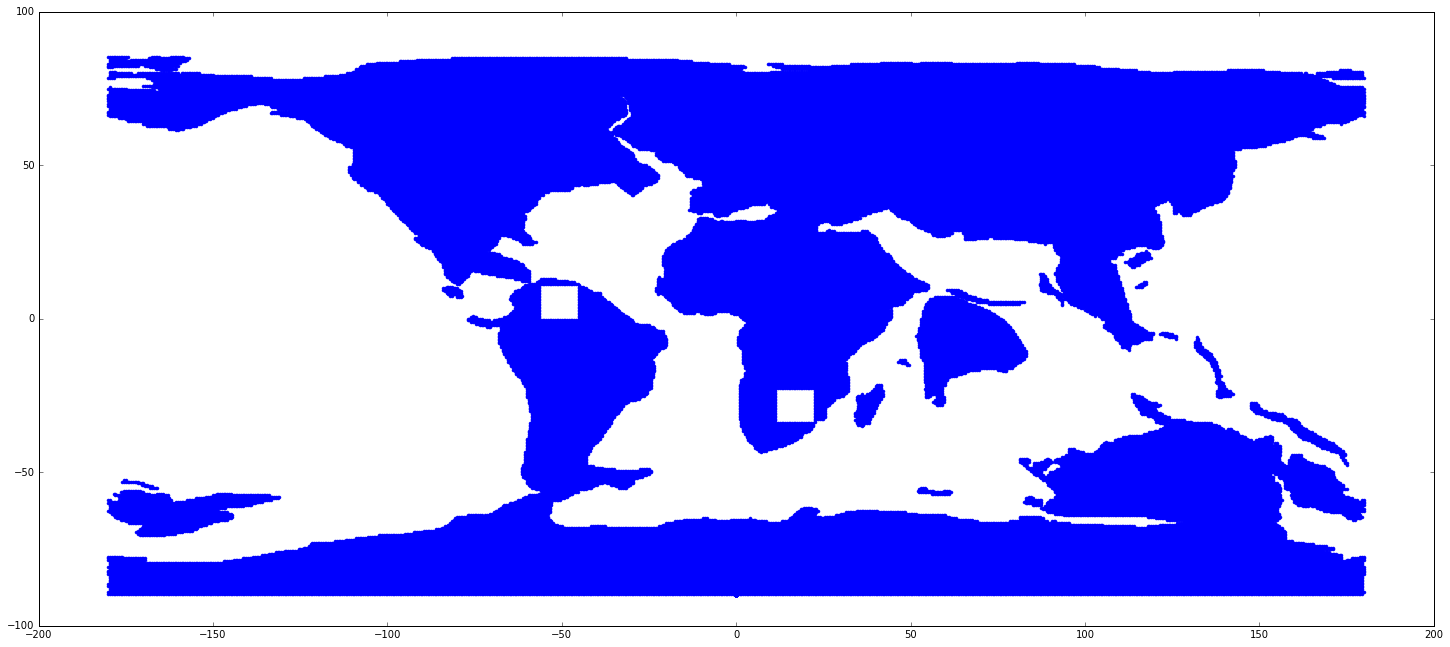

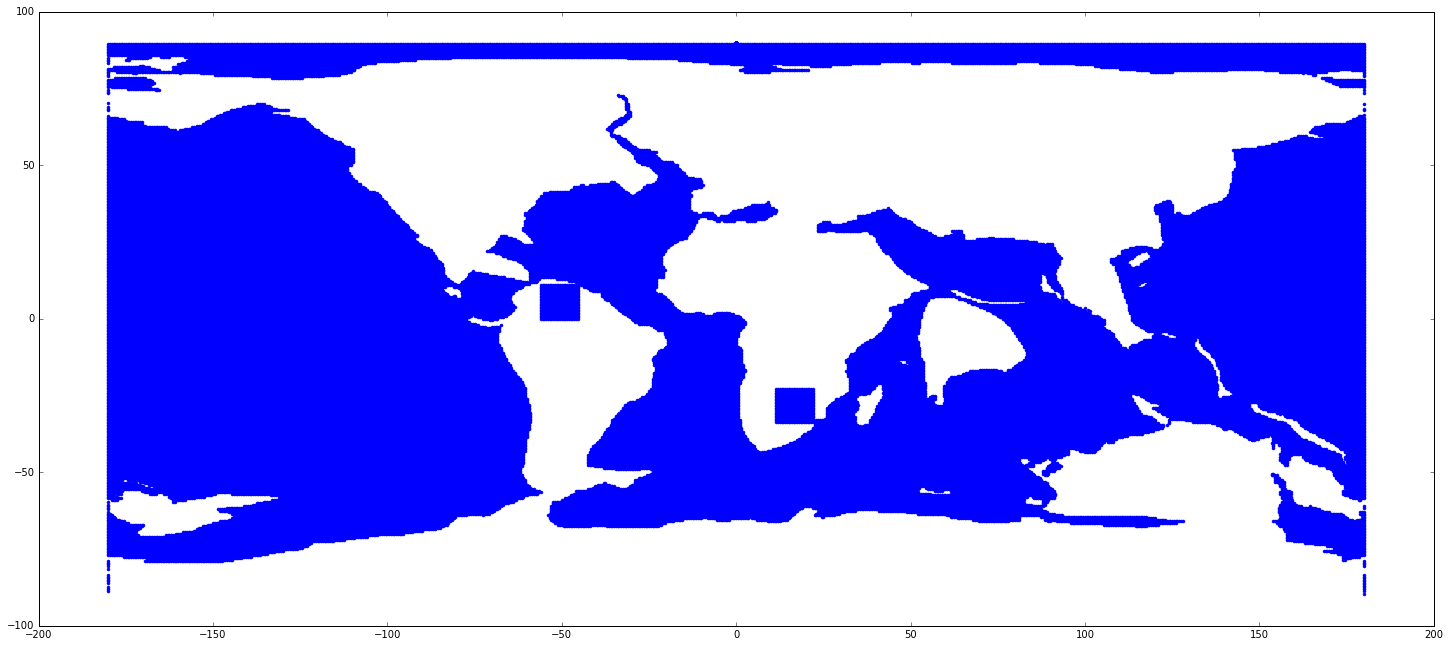

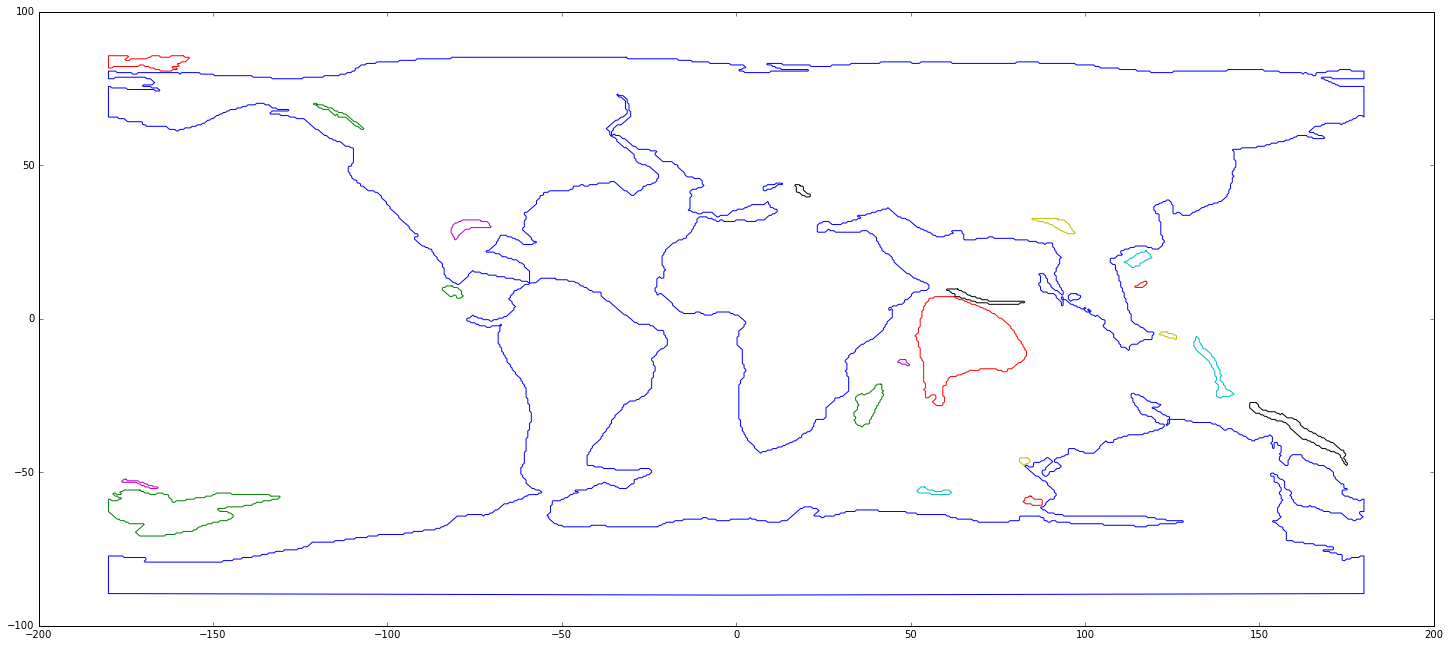

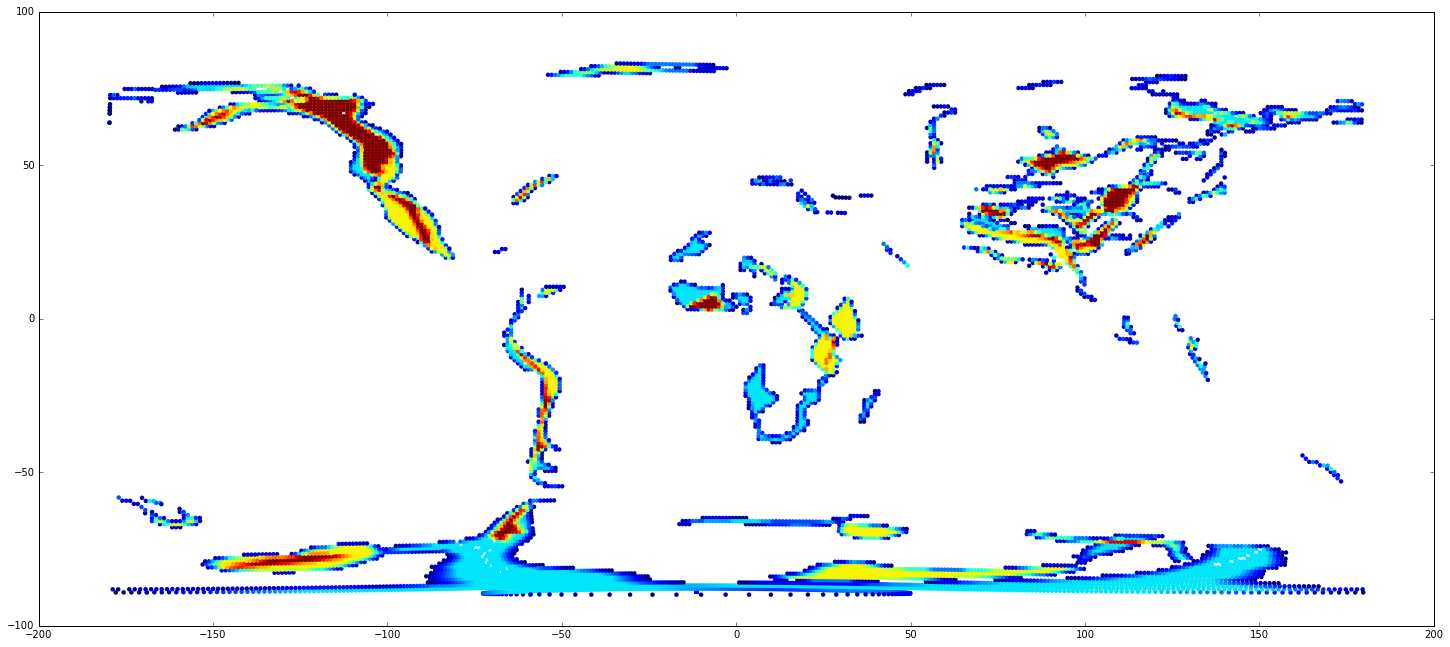

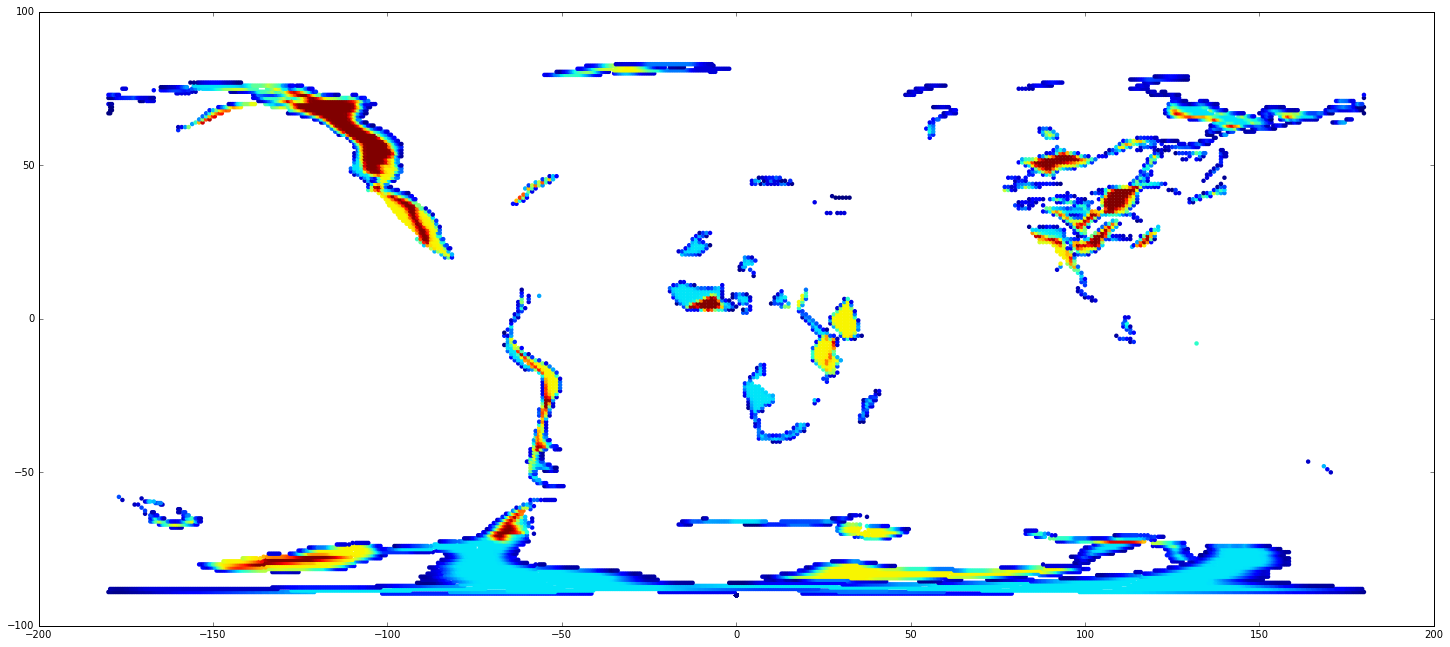

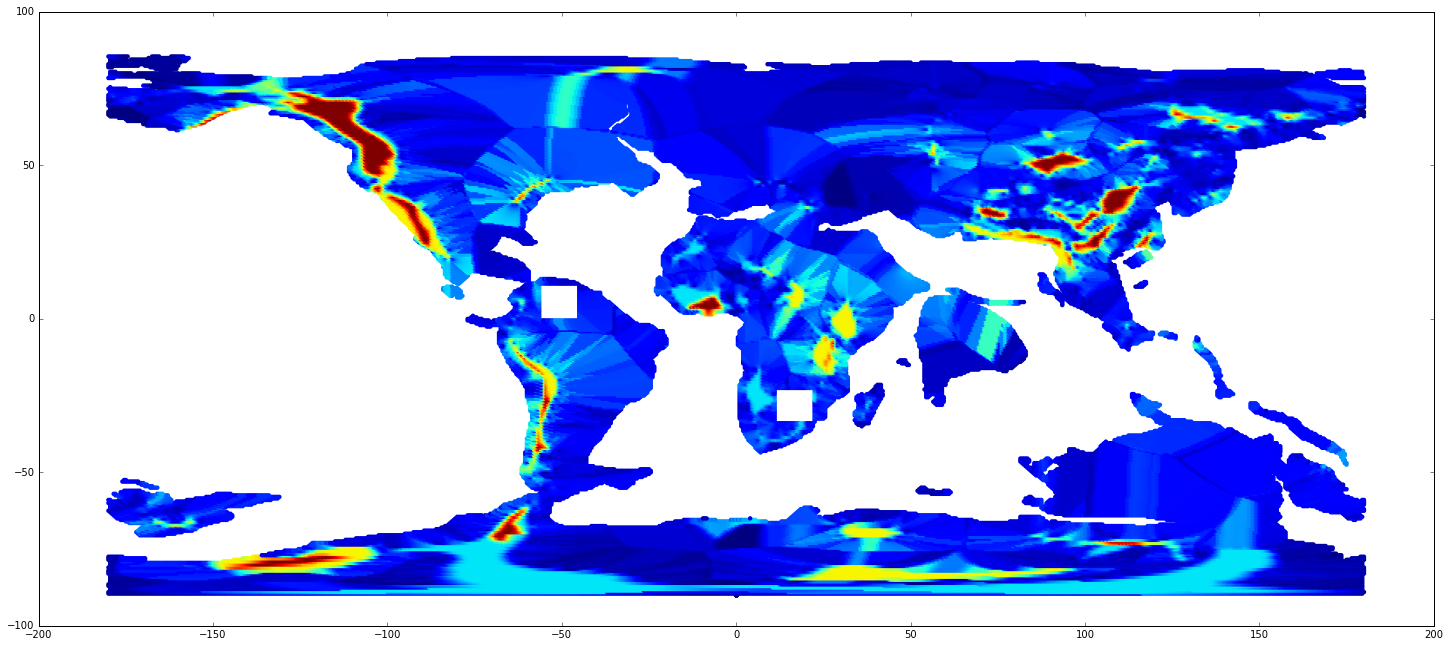

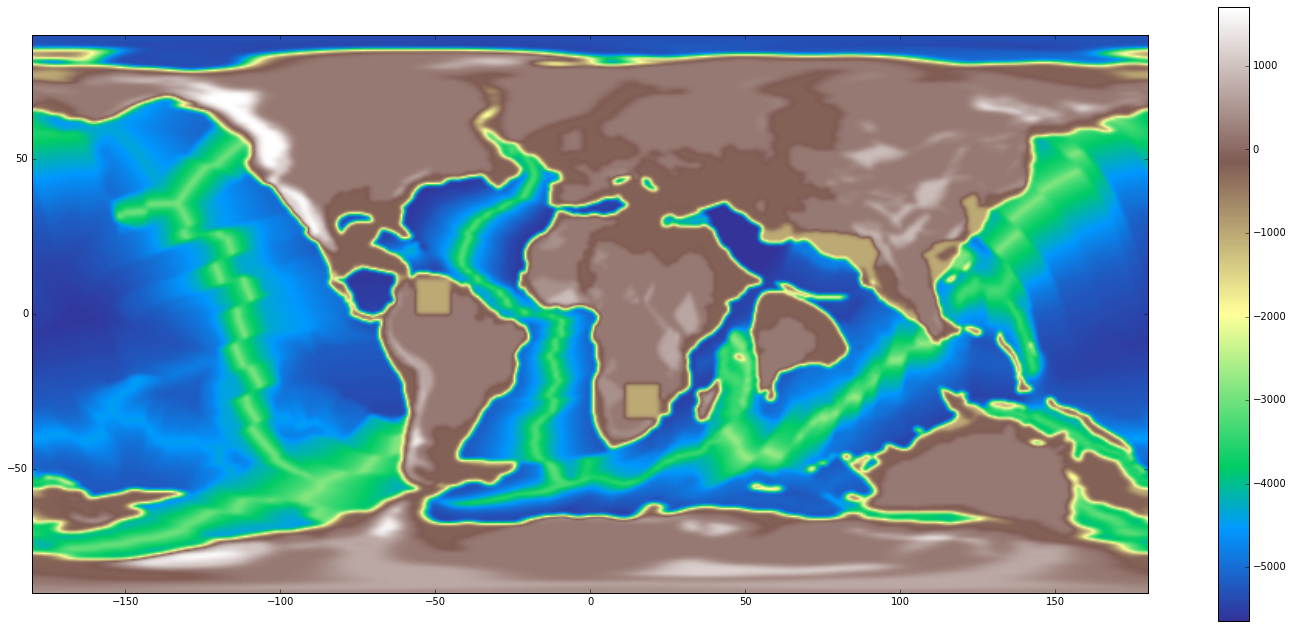

In [16]:
time_min = 61.
time_max = 231.
time_step = 1

for reconstruction_time in np.arange(time_min,time_max+time_step,time_step):

    print 'Working on Time %0.2fMa\n' % reconstruction_time 
        
    # find times that bracket the selected exact time in the paleogeography source files
    time_stage_max = time_list[np.where(time_list>reconstruction_time)[0][0]]
    time_stage_min = time_list[np.where(time_list<=reconstruction_time)[0][-1]]

    # Note the logic for selecting the times:
    # The main issue is that each set of paleogeography polygons has a defined 'midpoint' time
    # --> if the reconstruction time is between these, the choice of t1 and t2 is obvious
    # --> if the reconstruction time matches one of these times, then we can work directly on
    #     the geometries that match this time - hence the two routes through the if statement below
    
    print 'Selected Time is in the stage %0.2fMa to %0.2fMa' % (time_stage_min,time_stage_max)


    land_points_file = '%s/tweentest_land_%0.2fMa_%0.2fMa.gpmlz' % (tween_basedir,time_stage_min,time_stage_max)
    marine_points_file = '%s/tweentest_ocean_%0.2fMa_%0.2fMa.gpmlz' % (tween_basedir,time_stage_min,time_stage_max)
    mountains_going_up_file = '%s/mountain_transgression_%0.2fMa_%0.2fMa.gpmlz' % (tween_basedir,time_stage_min,time_stage_max)
    mountains_going_down_file = '%s/mountain_regression_%0.2fMa_%0.2fMa.gpmlz' % (tween_basedir,time_stage_min,time_stage_max)
    mountains_stable_file = '%s/mountain_stable_%0.2fMa_%0.2fMa.gpmlz' % (tween_basedir,time_stage_min,time_stage_max)

    
    # get a nx3 array defining the points above sea-level, reconstructed to time of interest
    # columns are [lat, long, elevation assigned for lowland]
    land_point_array = add_reconstructed_points_to_xyz(land_points_file,
                                                       rotation_model,
                                                       reconstruction_time,
                                                       lowland_elevation)
    
    # get a nx3 array defining shallow marine areas, reconstructed to time of interest
    # columns are [lat, long, elevation assigned for shallow marine]
    marine_point_array = add_reconstructed_points_to_xyz(marine_points_file,
                                                         rotation_model,
                                                         reconstruction_time,
                                                         shallow_marine_elevation)
    
    # Note that the two arrays just created are based on 'regular' lat/long grids, but 
    # are not aligned with the regular lat/long grid that we want to output
    # since they are (usually) reconstructed to a different time from the one at which they
    # were created (and anyway may be at a different resolution to the grid sampling specified
    # here)

    # combine the previous two arrays
    pg_point_array = np.vstack((land_point_array,marine_point_array))

    # get a merged version of COB terranes, optionally excluding polygons that are small in area
    # TODO deal with donut polygons better
    sieve_polygons = get_merged_cob_terrane_polygons(COBterrane_file,reconstruction_time,sampling)

    # get arrays defining the land and sea based on which points fall within the COB terranes
    # NOTE this step is where we create the points that ARE on the regular lat/long grid we 
    # will ultimately output
    (lat,lon,zval,
     lat_deep,lon_deep,zval_deep) = get_land_sea_multipoints(sieve_polygons,sampling)


    # sample the land/marine points onto the points within the COB Terranes
    # This will fill the gaps that exist within continents, and average out overlaps
    d,l = sampleOnSphere(pg_point_array[:,0],pg_point_array[:,1],pg_point_array[:,2],
                         np.array(lat),np.array(lon),n=1)

    land_marine_interp_points = pg_point_array[:,2].ravel()[l]

    # At this point, the land points are all considered to be 'lowland'......
    
    # Deal with the mountains
    if np.equal(reconstruction_time,time_stage_min):
        print 'Temporary hack for valid time'
        #dat3 = add_reconstructed_points_to_xyz(mountains_going_up_file,rotation_model,reconstruction_time,3)
        dat4 = add_reconstructed_points_to_xyz(mountains_going_down_file,rotation_model,reconstruction_time+0.01,3)
        dat5 = add_reconstructed_points_to_xyz(mountains_stable_file,rotation_model,reconstruction_time+0.01,3)
        mountains_tr_point_array = np.vstack((dat4,dat5))
        
        dist_tr = get_distance_to_mountain_edge(mountains_tr_point_array,reconstruction_basedir,reconstruction_time)
        dist_tr_cap = np.array(dist_tr)
        dist_tr_cap[np.array(dist_tr)>mountain_buffer_distance_degrees] = mountain_buffer_distance_degrees

        normalized_mountain_elevation = dist_tr_cap
        
    else:
        # load in the mountain points but at three different times: t1 and t2, and the reconstruction time
        # note that these three arrays should all be identical in size, since they are the same multipoints
        # just reconstructed to three slightly different times
        dat3 = add_reconstructed_points_to_xyz(mountains_going_up_file,rotation_model,time_stage_max,3)
        dat4 = add_reconstructed_points_to_xyz(mountains_going_down_file,rotation_model,time_stage_max,3)
        dat5 = add_reconstructed_points_to_xyz(mountains_stable_file,rotation_model,time_stage_max,3)
        mountains_t2_point_array = np.vstack((dat3,dat4,dat5))

        dat3 = add_reconstructed_points_to_xyz(mountains_going_up_file,rotation_model,time_stage_min+0.01,3)
        dat4 = add_reconstructed_points_to_xyz(mountains_going_down_file,rotation_model,time_stage_min+0.01,3)
        dat5 = add_reconstructed_points_to_xyz(mountains_stable_file,rotation_model,time_stage_min+0.01,3)
        mountains_t1_point_array = np.vstack((dat3,dat4,dat5))

        dat3 = add_reconstructed_points_to_xyz(mountains_going_up_file,rotation_model,reconstruction_time,3)
        dat4 = add_reconstructed_points_to_xyz(mountains_going_down_file,rotation_model,reconstruction_time,3)
        dat5 = add_reconstructed_points_to_xyz(mountains_stable_file,rotation_model,reconstruction_time,3)
        mountains_tr_point_array = np.vstack((dat3,dat4,dat5))

        # calculate distances of the mountain points to the edge of the mountain region at t1 and t2,
        # using the pg polygons that they should exactly correspond to 
        dist_t1 = get_distance_to_mountain_edge(mountains_t1_point_array,reconstruction_basedir,time_stage_min)
        dist_t2 = get_distance_to_mountain_edge(mountains_t2_point_array,reconstruction_basedir,time_stage_max)


        # cap the distances at some arbitrary value defined earlier
        dist_t1_cap = np.array(dist_t1)
        dist_t1_cap[np.array(dist_t1)>mountain_buffer_distance_degrees] = mountain_buffer_distance_degrees

        dist_t2_cap = np.array(dist_t2)
        dist_t2_cap[np.array(dist_t2)>mountain_buffer_distance_degrees] = mountain_buffer_distance_degrees

        # get the normalised time within this time stage
        # for example we are at 0.25 between the t1 and t2
        t_diff = (time_stage_max-time_stage_min)
        t_norm = (reconstruction_time-time_stage_min)/t_diff
        print t_diff, t_norm

        # use 1d interpolation to get the 'normalized' height of the mountains at the preceding
        # and subsequent times to the specific reconstruction time
        # [note this is not spatial interpolation - rather it is interpolation at each individual point
        # between the heights at earlier and later times]
        tmp = np.vstack((dist_t1_cap,dist_t2_cap))
        f = interpolate.interp1d([0,1],tmp.T)
        normalized_mountain_elevation = f(t_norm)
    
    
    #plt.figure(figsize=(25,11))
    #plt.plot(mountains_tr_point_array[:,1],mountains_tr_point_array[:,0],'.')
    
    # interpolate the elevations at tr onto the regular long lat points that we will ultimately use 
    # for the grid output
    # note the k value here controls number of neighbouring points used in inverse distance average
    d,l = sampleOnSphere(mountains_tr_point_array[:,0],mountains_tr_point_array[:,1],normalized_mountain_elevation,
                         np.array(lat),np.array(lon),k=4)
    w = 1./d**2
    normalized_mountain_elevation_interp_points = np.sum(w * normalized_mountain_elevation.ravel()[l],axis=1) / np.sum(w,axis=1)

    # this index isolates only those points that are within a certain distance of the mountain range
    # (since the interpolation will give values everywhere in the 'land', so we want to re-isolate only 
    # those points that fall within the 'mountain' regions)
    # TODO this should be set to the sampling??
    mountain_proximity_index = np.degrees(np.min(d,axis=1))< sampling/2. #mountain_buffer_distance_degrees

    plt.figure(figsize=(25,11))
    plt.scatter(mountains_tr_point_array[:,1],mountains_tr_point_array[:,0],
                c=normalized_mountain_elevation,edgecolor='')
    
    plt.figure(figsize=(25,11))
    plt.scatter(np.array(lon)[mountain_proximity_index],
                np.array(lat)[mountain_proximity_index],
                c=normalized_mountain_elevation_interp_points[mountain_proximity_index],edgecolor='')
    
    plt.figure(figsize=(25,11))
    plt.scatter(np.array(lon),
                np.array(lat),
                c=normalized_mountain_elevation_interp_points,edgecolor='')

    
    #####################################
    # Put the grid together
    #####################################
    
    # write the land/marine points to a file
    write_xyz_file('land_marine.xyz',zip(lon+lon_deep,
                                         lat+lat_deep,
                                         np.hstack((land_marine_interp_points,zval_deep))))

    # convert the normalized mountain elevations to metres, then write to file
    mountain_elevation_factor = max_mountain_elevation/mountain_buffer_distance_degrees
    write_xyz_file('mountain.xyz',zip(np.array(lon)[mountain_proximity_index],
                                      np.array(lat)[mountain_proximity_index],
                                      normalized_mountain_elevation_interp_points[mountain_proximity_index]*mountain_elevation_factor))

    # all the points are already on the same regular lat/long grid (but with gaps) - just 
    # need to piece them all together and combine.
    # Note we assume the the mountain elevation is the height IN ADDITION to the lowland elevation
    # so that we can simply add them
    os.system('gmt xyz2grd land_marine.xyz -Gland_marine.nc -Rd -I%0.8f' % sampling)
    os.system('gmt xyz2grd mountain.xyz -Gmountain.nc -Rd -I%0.8f -di0' % sampling)
    os.system('gmt grdmath mountain.nc land_marine.nc ADD = paleotopo.nc')

    # load result back into python
    topoX,topoY,topoZ = pg.load_netcdf('paleotopo.nc')

    
    # PALEOBATHYMETRY based on age grids
    # load age grid for this time and calculate paleobathymetry
    agegrid_file = agegrid_file_template % reconstruction_time

    ageX,ageY,ageZ = pg.load_netcdf(agegrid_file)

    paleodepth = pg.age2depth(ageZ,model='GDH1')


    # get index for grid nodes where age grid is nan, replace values with topography/shallow bathymetry
    not_bathy_index = np.isnan(paleodepth) 
    paleodepth[not_bathy_index] = topoZ[not_bathy_index]

    # save the merged grid (forcing compatibility with GPlates-readable netCDF in case it helps)
    ds = xr.DataArray(paleodepth,
                       coords=[('lat',topoY),('lon',topoX)])
    ds.to_netcdf('paleotopobathy.nc',format='NETCDF3_CLASSIC')

    # smooth the grid using GMT [wavelength is optional
    #pg.smooth_topography_grid('paleotopobathy.nc','paleotopobathy_smooth_%0.2fMa.nc' % reconstruction_time,400.)
    os.system('gmt grdfilter %s -G%s -Fg%0.2f -fg -D4 -Vl' % ('paleotopobathy.nc',
                                                             'paleotopobathy_smooth.nc',
                                                             grid_smoothing_wavelength_kms))
    
    # finally, once again force GPlates-readable netCDF (ie netCDF v3) and put the 
    # grid in the output folder with a filename containing the age
    os.system('gmt grdconvert %s -G%s=cf' % ('paleotopobathy_smooth.nc',
                                             '%s/paleotopobathy_smooth_%0.2fMa.nc' % (output_dir,reconstruction_time)))

    # load and plot the result
    topo_smoothX,topo_smoothY,topo_smoothZ = pg.load_netcdf('paleotopobathy_smooth.nc')
    #
    plt.figure(figsize=(25,11))
    plt.imshow(topo_smoothZ,origin='lower',
               extent=[-180,180,-90,90],cmap=plt.cm.terrain)
    plt.colorbar()

    break
    